In [1]:
# Import libraries
import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
import matplotlib.pyplot as plt
import datetime

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, r2_score

In [2]:
# Step 1: Download Stock Data

# Choose a stock ticker symbol
ticker = 'KBANK.BK'

# Download historical data from Yahoo Finance (period="5y")
data = yf.download(ticker, start='2020-01-01', end=datetime.datetime.today().strftime('%Y-%m-%d'), auto_adjust=True) #show adjusted close price

# Focus on Adj. Close prices for simplicity
data = data[['Close']]
print(data)

[*********************100%***********************]  1 of 1 completed

Price            Close
Ticker        KBANK.BK
Date                  
2020-01-02  128.455124
2020-01-03  127.618317
2020-01-06  120.086723
2020-01-07  119.668312
2020-01-08  117.157806
...                ...
2025-02-20  164.000000
2025-02-21  159.000000
2025-02-24  157.500000
2025-02-25  154.500000
2025-02-26  150.000000

[1250 rows x 1 columns]


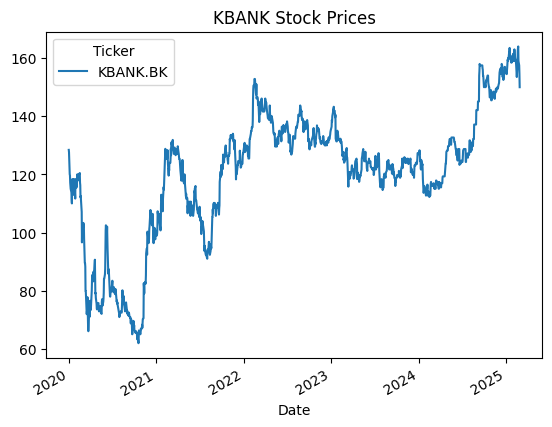

In [3]:
data['Close'].plot()
plt.title("KBANK Stock Prices")
plt.show()

In [26]:
data

Price,Close
Ticker,KBANK.BK
Date,
2021-01-04,99.018921
2021-01-05,99.895203
2021-01-06,102.085876
2021-01-07,107.343529
2021-01-08,106.467247
...,...
2025-02-19,163.500000
2025-02-20,164.000000


In [4]:
# Step 2: Preprocess Data

# Initialize MinMaxScaler to normalize the data between 0 and 1
scaler = MinMaxScaler(feature_range=(0,1))

# Scale the data for training
scaled_data = scaler.fit_transform(data)
scaled_data
# Handle missing values by forward filling
data.fillna(method='ffill', inplace=True)
scaled_data

/var/folders/vw/288jn05573d78l0mr6f151zc0000gn/T/ipykernel_18039/3160256962.py:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


array([[0.65153324],
       [0.64332954],
       [0.56949302],
       ...,
       [0.93627678],
       [0.90686606],
       [0.86274999]])

In [5]:


# Convert data to pandas DataFrame for further processing if needed
processed_data = pd.DataFrame(scaled_data, columns=['Close'])
print(processed_data)

         Close
0     0.651533
1     0.643330
2     0.569493
3     0.565391
4     0.540779
...        ...
1245  1.000000
1246  0.950982
1247  0.936277
1248  0.906866
1249  0.862750

[1250 rows x 1 columns]


In [6]:
# Step 3: Prepare Training Data

# Split into the training and testing sets
train_data, test_data = train_test_split(scaled_data, train_size=0.8, shuffle=False)

# Create empty lists for features (x_train) and target (y_train)
x_train = []
y_train = []
x_test = []
y_test = []

# Populate x_train with 60 days of data and y_train with the following day’s closing price
for i in range(20, len(train_data)):
    x_train.append(train_data[i-20:i, 0])  # Past 60 days
    y_train.append(train_data[i, 0])       # Target: the next day’s close price

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Prepare the test set in the same way
for i in range(20, len(test_data)):
    x_test.append(test_data[i-20:i, 0])  # Past 60 days
    y_test.append(test_data[i, 0])       # Target: the next day’s close price

x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}" if len(x_test) > 0 else "⚠️ No test set available.")
print(f"y_test shape: {y_test.shape}" if len(y_test) > 0 else "")

x_train shape: (980, 20, 1)
y_train shape: (980,)
x_test shape: (230, 20, 1)
y_test shape: (230,)


In [7]:
# Step 4: Build LSTM Model
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Create the LSTM model
model = Sequential()

# First LSTM layer with 50 units and return sequences
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))  # Dropout layer to prevent overfitting

# Second LSTM layer
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))  # Dropout layer to prevent overfitting

# Third LSTM layer with 50 units and return sequences=False
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))  # Dropout layer to prevent overfitting

# Dense layer with 25 units
model.add(Dense(units=25))

# Output layer with 1 unit (the predicted price)
model.add(Dense(units=1))

# Compile the model using Adam optimizer and mean squared error as the loss function
model.compile(optimizer='adam', loss='mean_squared_error')

# Print the model summary
model.summary()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 20, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 20, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 20, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,101 (203.52 KB)

 Trainable params: 52,101 (203.52 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Step 5: Train the Model

# Add EarlyStopping to monitor the loss and stop training if it doesn’t improve
early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

# Save the best model during training using ModelCheckpoint
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='loss', save_best_only=True)

# Train the model with batch size of 32 and for 50 epochs (can be adjusted)
history = model.fit(x_train, y_train, batch_size=32, epochs=50, callbacks=[early_stop, model_checkpoint], validation_split=0.2)

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.1112 - val_loss: 0.0064
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0137 - val_loss: 0.0024
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0081 - val_loss: 0.0014
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0085 - val_loss: 0.0021
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0075 - val_loss: 0.0016
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0071 - val_loss: 0.0011
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0068 - val_loss: 0.0010
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0058 - val_loss: 0.0011
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0058 - val_loss: 0.0015
Epoch 10/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0056 - val_loss: 0.0016
Epoch 11/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0056 - val_loss: 0.0011
Epoch 12/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0

In [9]:
# Step 6: Generate predictions for 30-day forecast

# Take the last 60 days from the dataset for generating future predictions
last_20_days = scaled_data[-20:]

# Reshape last_60_days to fit the model input shape
x_future = last_20_days.reshape((1, last_20_days.shape[0], 1))

# Generate predictions
predictions = []
for _ in range(30):
    pred = model.predict(x_future) # Predict the next day
    predictions.append(pred[0,0]) # Append the prediction to the list
    
    # Update x_future by removing the first value and appending the prediction at the end
    x_future = np.append(x_future[:, 1:, :], np.array([[pred[0, 0]]]).reshape(1, 1, 1), axis=1)

# Inverse transform the predictions to get them back to the original scale
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Convert predictions to a DataFrame
future_dates = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=30)
predictions_df = pd.DataFrame(predictions, index=future_dates, columns=['Predicted Close'])
print(predictions_df)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━

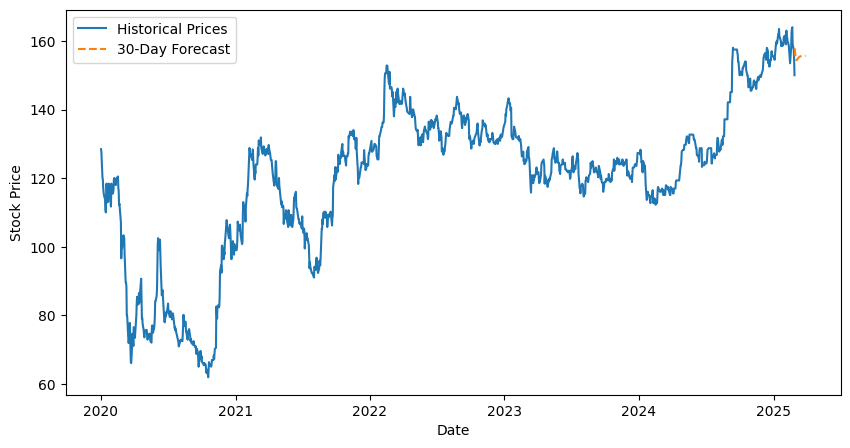

In [10]:
# Plot historical data and future predictions for comparison
plt.figure(figsize=(10, 5))
plt.plot(data['Close'], label='Historical Prices')
plt.plot(predictions_df, label='30-Day Forecast', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  
Mean Squared Error: 6.874937219691016
Mean Absolute Error: 1.8963059798530906
Root Mean Squared Error: 2.6220101486628566


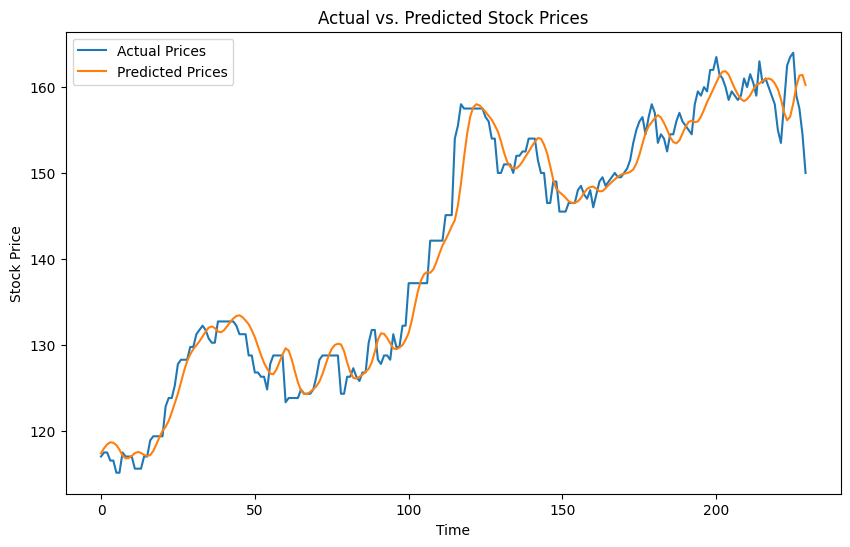

In [11]:
# Step 7: Evaluationg model

# Make predictions on the test set
test_predictions = model.predict(x_test)

# Inverse transform the predictions to get them back to the original scale
test_predictions = scaler.inverse_transform(test_predictions)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test_rescaled, test_predictions)
print(f"Mean Squared Error: {mse}")

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_rescaled, test_predictions)
print(f"Mean Absolute Error: {mae}")

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error: {rmse}")

# Plot the actual vs. predicted prices
plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled, label='Actual Prices')
plt.plot(test_predictions, label='Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Actual vs. Predicted Stock Prices')
plt.legend()
plt.show()

# 4 years with 30 days window
# Mean Squared Error: 8.780986955905801
# Mean Absolute Error: 2.2250877202943316
# Root Mean Squared Error: 2.963273014068363

# 5 years with 20 days window
# Mean Squared Error: 6.874937219691016
# Mean Absolute Error: 1.8963059798530906
# Root Mean Squared Error: 2.6220101486628566

# 5 years with 30 days window
# Mean Squared Error: 7.497023905151185
# Mean Absolute Error: 2.054899735884233
# Root Mean Squared Error: 2.738069375518302

# 5 years with 60 days window
# Mean Squared Error: 8.789918645134037
# Mean Absolute Error: 2.2588911759225945
# Root Mean Squared Error: 2.9647796958853516

# 6 years with 30 days window
# Mean Squared Error: 7.352593604620238
# Mean Absolute Error: 2.036884974369772
# Root Mean Squared Error: 2.711566632893287

In [30]:
# Calculate the accuracy 
def calculate_accuracy(y_true, y_pred):
    n = len(y_true)
    accuracy = np.sum(np.abs(y_pred - y_true)) / n
    return accuracy

# Actual closing prices (test set)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Predicted closing prices
test_predictions = model.predict(x_test)
test_predictions = scaler.inverse_transform(test_predictions)

# Calculate accuracy
accuracy = calculate_accuracy(y_test_rescaled, test_predictions)
print(f"Accuracy: {accuracy:.2f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Accuracy: 2.77


In [13]:
# Calculate MAPE
mape = mean_absolute_percentage_error(y_test_rescaled, test_predictions)
print(f"Mean Absolute Percentage Error (MAPE): {mape * 100:.2f}%")

Mean Absolute Percentage Error (MAPE): 1.51%


In [46]:
# TO DO NEXT
# 1. model performance evaluation in %
# 2. integrating indicators
# 3. Predict with different period
# 4. trigger 
# 5. set baseline >> 80% (r2 = 0.8)
# 6. Improve model: Hyperparameter Tuning, Data Preprocessing, Model Complexity
# 7. Receive input: stock ticker
# 8. Output (add 1 more function: comparison between stocks to find the best) 1 file 1 industry 

In [32]:
r2_score(y_test_rescaled, test_predictions)

0.4584080888554717